# Code to generate random incompressible flow snap-shots

In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

2023-01-06 11:08:59.256752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 11:08:59.405171: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-06 11:09:00.194913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jkumar/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/cuda-11.7/lib64:/usr/local/cuda/extras/CUPTI/lib64
2023-01-06 11:09:00.194989: W tensorflow/str

## Parameters

In [2]:
GridSize = 100
SmoothenSigma = 20
MaxShift = 3

## Random seed-field

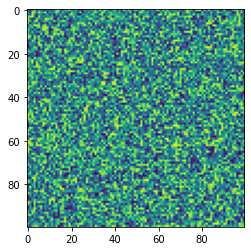

In [3]:
RandomField = np.random.rand( GridSize , GridSize )

plt.imshow( RandomField )
plt.show()

## Smooth the random field

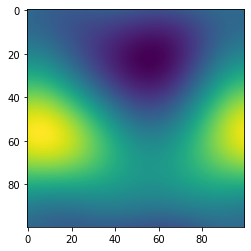

In [4]:
StreamFunction = sp.gaussian_filter( RandomField , sigma=SmoothenSigma , mode='wrap' )

plt.imshow( StreamFunction )
plt.show()

## Flow from stream function: $\psi$
### For any smooth random scalar field $\psi$, the velocity field is given by
### $ \vec{u} = \nabla \times \psi $
### such that, $\nabla . \vec{u} = 0$, i.e. incompressible.

## Calculation of velocity field

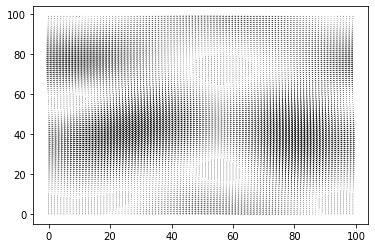

In [5]:
Vx =  np.gradient( StreamFunction , axis=0 )
Vy = -np.gradient( StreamFunction , axis=1 )

plt.quiver( Vx , Vy , units='width' )
plt.show()

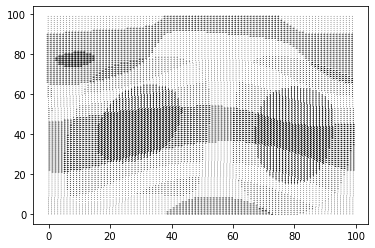

In [6]:
MagV = np.sqrt( Vx * Vx + Vy * Vy )
MaxMagV = np.max( MagV )

Vx = np.round( Vx * MaxShift / MaxMagV )
Vy = np.round( Vy * MaxShift / MaxMagV )

plt.quiver( Vx , Vy , units='width' )
plt.show()

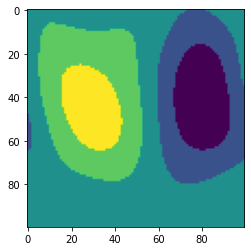

In [7]:
plt.imshow(Vy)

In [8]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

for XShift in range(-MaxShift , MaxShift):
    for YShift in range(-MaxShift , MaxShift):
        I = ((Vx>XShift) * (Vy>YShift))

        OverlayFrame = np.random.rand( GridSize , GridSize )

        Frame1 = Frame1 * (1-I) + OverlayFrame * I

        I = np.roll( I , XShift , axis=0 )
        I = np.roll( I , YShift , axis=1 )

        OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
        OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

        Frame2 = Frame2 * (1-I) + OverlayFrame * I

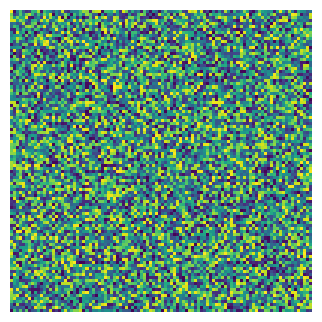

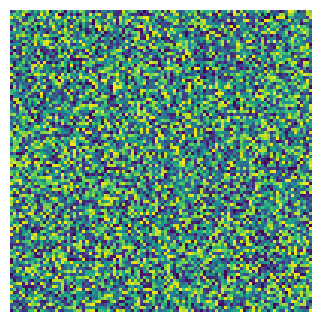

In [9]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame1 )
plt.axis('off')
plt.savefig('Frame1.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame2 )
plt.axis('off')
plt.savefig('Frame2.png',bbox_inches='tight',transparent=False,pad_inches = 0)

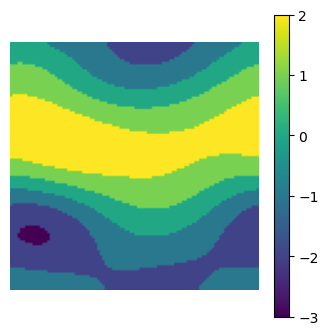

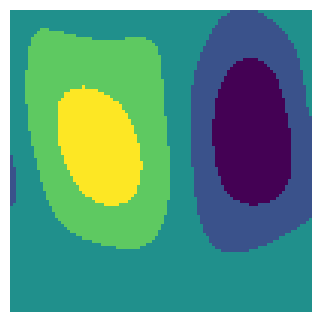

In [10]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vx )
plt.colorbar()
plt.axis('off')
plt.savefig('Vx.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vy )
plt.axis('off')
plt.savefig('Vy.png',bbox_inches='tight',transparent=False,pad_inches = 0)

In [11]:
DataSize = 100000
WindowSize = 8
LabelSize = 2*MaxShift + 1

Height, Width = Frame1.shape
HalfWindowSize = int( WindowSize/2 )

TrainImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TrainLabels = np.zeros([DataSize,1],dtype=np.uint8)

In [12]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift
    YYShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift+YYShift,XShift+XXShift) , axis=(0,1) )

    TrainImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TrainImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TrainLabels[i,0] = XXShift + MaxShift

In [13]:
TestImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TestLabels = np.zeros([DataSize,1],dtype=np.uint8)

In [14]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift
    YYShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift+YYShift,XShift+XXShift) , axis=(0,1) )

    TestImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TestImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TestLabels[i,0] = XXShift + MaxShift

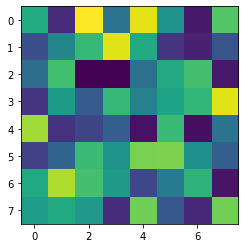

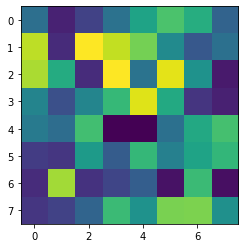

In [15]:
plt.imshow(TrainImages[1,:,:,0])
plt.show()

plt.imshow(TrainImages[1,:,:,1])
plt.show()

In [16]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(WindowSize, WindowSize, 2)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense( 2*MaxShift+1 ))

2023-01-06 11:09:16.367670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 11:09:16.400650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 11:09:16.400860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 11:09:16.401264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 8,711
Trainable params: 8,711
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile( optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(TrainImages, TrainLabels, epochs=100, 
                    validation_data=(TestImages, TestLabels))

Epoch 1/100
3125/3125 [==============================] - 8s 2ms/step - loss: 1.7682 - accuracy: 0.2086 - val_loss: 1.6498 - val_accuracy: 0.3052
Epoch 2/100
3125/3125 [==============================] - 7s 2ms/step - loss: 1.4199 - accuracy: 0.4373 - val_loss: 1.2088 - val_accuracy: 0.5405
Epoch 3/100
3125/3125 [==============================] - 7s 2ms/step - loss: 1.0123 - accuracy: 0.6396 - val_loss: 0.8379 - val_accuracy: 0.7144
Epoch 4/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.7265 - accuracy: 0.7487 - val_loss: 0.6526 - val_accuracy: 0.7685
Epoch 5/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.6082 - accuracy: 0.7846 - val_loss: 0.5774 - val_accuracy: 0.7949
Epoch 6/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5511 - accuracy: 0.8037 - val_loss: 0.5177 - val_accuracy: 0.8169
Epoch 7/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5085 - accuracy: 0.8172 - val_loss: 0.5208 - val_ac

In [19]:
ii = 570
print( np.argmax(model.predict( TrainImages[ii:(ii+1)] )) )
print( TrainLabels[ii:(ii+1)] )

1/1 [==============================] - 0s 67ms/step
3
[[3]]


In [20]:
PredictedLabel=np.argmax(model.predict( TestImages ),axis=1)

3125/3125 [==============================] - 3s 823us/step


In [21]:
Input = np.zeros([Width*Height,WindowSize,WindowSize,2])

In [22]:
k = 0

for i in range(Height):
    for j in range(Width):

        ShiftedFrame1 = np.roll( Frame1 , (i,j) , axis=(0,1) )
        ShiftedFrame2 = np.roll( Frame2 , (i,j) , axis=(0,1) )

        Input[k,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
        Input[k,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

        k = k+1

In [23]:
PredictedLabel = np.argmax(model.predict( Input ),axis=1)

313/313 [==============================] - 0s 786us/step


In [24]:
PredictedVx = np.reshape( PredictedLabel , [Width,Height] )

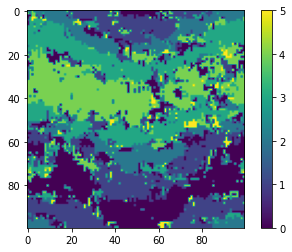

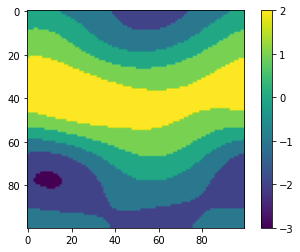

In [25]:
plt.imshow( np.rot90(np.rot90(PredictedVx)) )
plt.colorbar()
plt.show()

plt.imshow( Vx )
plt.colorbar()
plt.show()

In [26]:
np.min(PredictedVx)

0